In [61]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [20]:
df_dev = load_dataset("csv", data_files="subtaskA_train.csv")
df_test = load_dataset("csv", data_files="subtaskA_test.csv")

Found cached dataset csv (C:/Users/irene/.cache/huggingface/datasets/csv/default-9117625add939e31/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset csv (C:/Users/irene/.cache/huggingface/datasets/csv/default-3cb4956ee4561a2a/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

# Data partioning

In [21]:
train_val = df_dev['train'].train_test_split(test_size=0.3) # inserire random state
train_val

DatasetDict({
    train: Dataset({
        features: ['Id', 'comment_text', 'conspiratorial'],
        num_rows: 1289
    })
    test: Dataset({
        features: ['Id', 'comment_text', 'conspiratorial'],
        num_rows: 553
    })
})

In [22]:
df_train = train_val["train"]
df_val = train_val["test"]

In [23]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val = df_val.rename_column("comment_text", "text")
df_val = df_val.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

# Model loading

In [48]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Data preprocessing

In [49]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [50]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\irene\.cache\huggingface\datasets\csv\default-9117625add939e31\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-3601015709e15594.arrow


Map:   0%|          | 0/553 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\irene\.cache\huggingface\datasets\csv\default-3cb4956ee4561a2a\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-f1e74efaca89caa9.arrow


In [51]:
tokenized_train

Dataset({
    features: ['Id', 'text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1289
})

In [74]:
small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

Loading cached shuffled indices for dataset at C:\Users\irene\.cache\huggingface\datasets\csv\default-9117625add939e31\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-f5583e8030c0431d.arrow
Loading cached shuffled indices for dataset at C:\Users\irene\.cache\huggingface\datasets\csv\default-9117625add939e31\0.0.0\eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d\cache-567b0f12b7802c8b.arrow


# Training

In [97]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    logging_strategy="epoch",
    num_train_epochs=15,
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0
    )

In [98]:
config = AutoConfig.from_pretrained("bert-base-multilingual-uncased")

In [84]:
#config.classifier_dropout = 0.001

In [99]:
print(config)

BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 105879
}



In [100]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-uncased", config=config)

model

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [87]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [101]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

In [102]:
trainer.train()

c:\Users\irene\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

{'loss': 0.7038, 'learning_rate': 4.666666666666667e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.716465175151825, 'eval_f1': 0.25, 'eval_runtime': 7.8175, 'eval_samples_per_second': 0.384, 'eval_steps_per_second': 0.128, 'epoch': 1.0}
{'loss': 0.6603, 'learning_rate': 4.3333333333333334e-05, 'epoch': 2.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7122576832771301, 'eval_f1': 0.25, 'eval_runtime': 7.8051, 'eval_samples_per_second': 0.384, 'eval_steps_per_second': 0.128, 'epoch': 2.0}
{'loss': 0.6386, 'learning_rate': 4e-05, 'epoch': 3.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7087042331695557, 'eval_f1': 0.25, 'eval_runtime': 8.3374, 'eval_samples_per_second': 0.36, 'eval_steps_per_second': 0.12, 'epoch': 3.0}
{'loss': 0.6057, 'learning_rate': 3.6666666666666666e-05, 'epoch': 4.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7053255438804626, 'eval_f1': 0.25, 'eval_runtime': 8.0654, 'eval_samples_per_second': 0.372, 'eval_steps_per_second': 0.124, 'epoch': 4.0}
{'loss': 0.5785, 'learning_rate': 3.3333333333333335e-05, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7047666907310486, 'eval_f1': 0.25, 'eval_runtime': 8.373, 'eval_samples_per_second': 0.358, 'eval_steps_per_second': 0.119, 'epoch': 5.0}
{'loss': 0.3962, 'learning_rate': 3e-05, 'epoch': 6.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.7221307754516602, 'eval_f1': 0.25, 'eval_runtime': 8.0549, 'eval_samples_per_second': 0.372, 'eval_steps_per_second': 0.124, 'epoch': 6.0}
{'loss': 0.3786, 'learning_rate': 2.6666666666666667e-05, 'epoch': 7.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.757162868976593, 'eval_f1': 0.25, 'eval_runtime': 8.3679, 'eval_samples_per_second': 0.359, 'eval_steps_per_second': 0.12, 'epoch': 7.0}
{'loss': 0.2972, 'learning_rate': 2.3333333333333336e-05, 'epoch': 8.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.8090426921844482, 'eval_f1': 0.25, 'eval_runtime': 8.2199, 'eval_samples_per_second': 0.365, 'eval_steps_per_second': 0.122, 'epoch': 8.0}
{'loss': 0.2355, 'learning_rate': 2e-05, 'epoch': 9.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.8731274008750916, 'eval_f1': 0.25, 'eval_runtime': 9.9316, 'eval_samples_per_second': 0.302, 'eval_steps_per_second': 0.101, 'epoch': 9.0}
{'loss': 0.2084, 'learning_rate': 1.6666666666666667e-05, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9259122014045715, 'eval_f1': 0.25, 'eval_runtime': 8.4364, 'eval_samples_per_second': 0.356, 'eval_steps_per_second': 0.119, 'epoch': 10.0}
{'loss': 0.1486, 'learning_rate': 1.3333333333333333e-05, 'epoch': 11.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9502480626106262, 'eval_f1': 0.25, 'eval_runtime': 8.9452, 'eval_samples_per_second': 0.335, 'eval_steps_per_second': 0.112, 'epoch': 11.0}
{'loss': 0.1353, 'learning_rate': 1e-05, 'epoch': 12.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9568642973899841, 'eval_f1': 0.25, 'eval_runtime': 7.0189, 'eval_samples_per_second': 0.427, 'eval_steps_per_second': 0.142, 'epoch': 12.0}
{'loss': 0.1058, 'learning_rate': 6.666666666666667e-06, 'epoch': 13.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9653447270393372, 'eval_f1': 0.25, 'eval_runtime': 7.4667, 'eval_samples_per_second': 0.402, 'eval_steps_per_second': 0.134, 'epoch': 13.0}
{'loss': 0.091, 'learning_rate': 3.3333333333333333e-06, 'epoch': 14.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9739176630973816, 'eval_f1': 0.25, 'eval_runtime': 6.1812, 'eval_samples_per_second': 0.485, 'eval_steps_per_second': 0.162, 'epoch': 14.0}
{'loss': 0.0876, 'learning_rate': 0.0, 'epoch': 15.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.9784182906150818, 'eval_f1': 0.25, 'eval_runtime': 6.1514, 'eval_samples_per_second': 0.488, 'eval_steps_per_second': 0.163, 'epoch': 15.0}
{'train_runtime': 552.9082, 'train_samples_per_second': 0.163, 'train_steps_per_second': 0.027, 'train_loss': 0.35141346603631973, 'epoch': 15.0}


TrainOutput(global_step=15, training_loss=0.35141346603631973, metrics={'train_runtime': 552.9082, 'train_samples_per_second': 0.163, 'train_steps_per_second': 0.027, 'train_loss': 0.35141346603631973, 'epoch': 15.0})

# Evaluation

In [103]:
log_history = trainer.state.log_history

In [104]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
df

C:\Users\irene\AppData\Local\Temp\ipykernel_8036\2467079435.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
C:\Users\irene\AppData\Local\Temp\ipykernel_8036\2467079435.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
C:\Users\irene\AppData\Local\Temp\ipykernel_8036\2467079435.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
C:\Users\irene\AppData\Local\Temp\ipykernel_8036\2467079435.py:10: FutureWarning: The frame.append method is deprecated and wil

,Epoch,Loss,Dataset
0,1,0.703800,Training
1,1,0.716465,Validation
2,2,0.660300,Training
3,2,0.712258,Validation
4,3,0.638600,Training
5,3,0.708704,Validation
6,4,0.605700,Training
7,4,0.705326,Validation
8,5,0.578500,Training
9,5,0.704767,Validation


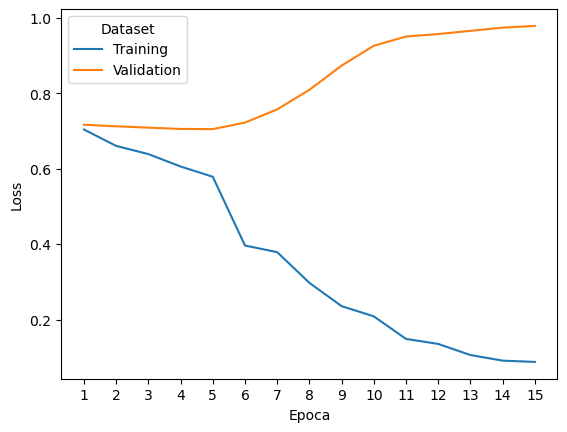

In [107]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig('loss_curves_BERT-base_default_params.pdf', dpi=300, bbox_inches='tight')
plt.show()